In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from collections import Counter
from scipy.signal import find_peaks
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import matplotlib.colors as colors
from sklearn.manifold import Isomap
import keras_tuner
from keras_tuner.tuners import Hyperband

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

/wrk-vakka/users/sfniila/venv/lib/python3.6/site-packages/ipykernel_launcher.py:187: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/wrk-vakka/users/sfniila/venv/lib/python3.6/site-packages/ipykernel_launcher.py:189: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/wrk-vakka/users/sfniila/venv/lib/python3.6/site-packages/ipykernel_launcher.py:187: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

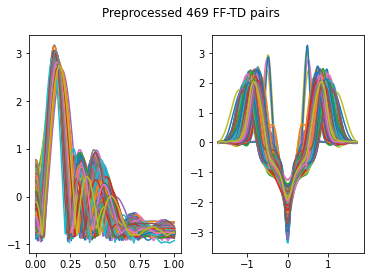

(375, 1000)
(375, 400)
(94, 1000)
(94, 400)


In [3]:
def get_peak_data(FF_df,TD_y_df):
    FF_min_and_max_points = []
    FF_min_and_max_points_amounts = []
    
    TD_min_and_max_points = []
    TD_min_and_max_points_amounts = []
    
    for column in FF_df.columns:
        max_peaks_FF, _ = find_peaks(FF_df[column])
        min_peaks_FF, _ = find_peaks(-FF_df[column])
        
        FF_peak_indexes = np.hstack((max_peaks_FF, min_peaks_FF))
        FF_peak_indexes.sort()
        FF_peak_value = FF_df[column][FF_peak_indexes]
        
        FF_min_and_max_points.append(list(FF_peak_value))
        FF_min_and_max_points_amounts.append([len(min_peaks_FF), len(max_peaks_FF)])
        
        max_peaks_TD, _ = find_peaks(TD_y_df[column])
        min_peaks_TD, _ = find_peaks(-TD_y_df[column])
        
        TD_peak_indexes = np.hstack((max_peaks_TD, min_peaks_TD))
        TD_peak_indexes.sort()
        TD_peak_value = TD_y_df[column][TD_peak_indexes]
         
        TD_min_and_max_points.append(list(TD_peak_value))
        TD_min_and_max_points_amounts.append([len(min_peaks_TD), len(max_peaks_TD)])
        
    FF_peak_df = pd.DataFrame(FF_min_and_max_points)
    FF_peak_df = FF_peak_df.transpose()
    FF_peak_df.columns = FF_df.columns
    
    TD_peak_df = pd.DataFrame(TD_min_and_max_points)
    TD_peak_df = TD_peak_df.transpose()
    TD_peak_df.columns = TD_y_df.columns
    
    return FF_peak_df, FF_min_and_max_points_amounts, TD_peak_df, TD_min_and_max_points_amounts 

def get_common_peak_samples(FF_df,TD_x_df,TD_y_df,FF_peak_df,TD_peak_df,s_p):
    FF_n_nans = FF_peak_df.isna().sum(axis=0)
    FF_peak_freq = FF_peak_df.isna().sum(axis=0).value_counts().values
    FF_peak_values = FF_peak_df.isna().sum(axis=0).value_counts().index
    
    sample_amount = round(FF_peak_df.shape[1]*s_p,1)
    found_amount = 0
    sample_nans = []
    i = 0
    for nans in FF_peak_values:
        if found_amount < sample_amount:
            sample_nans.append(nans)
            found_amount = found_amount + FF_peak_freq[i]
        i = i + 1
        
    Common_peak_FF_columns = set()
    filtered_peaks = [] 
    for nans in sample_nans:
        column_names = FF_n_nans[FF_n_nans == nans].index
        
        for column in FF_peak_df[column_names].columns:
            Common_peak_FF_columns.add(column)
            filtered_peaks.append(FF_peak_df[column])
     
    Common_peak_FF_columns = list(Common_peak_FF_columns)
    peak_filtered_FF_df = pd.DataFrame(filtered_peaks)
    peak_filtered_FF_df = peak_filtered_FF_df.transpose()
    peak_filtered_FF_df.columns = Common_peak_FF_columns
    
    Removed_cases = random.sample(Common_peak_FF_columns,int(found_amount-sample_amount))
    Samples = []
    for column in Common_peak_FF_columns:
        if column in Removed_cases:
            continue
        Samples.append(column)
    Samples.sort()
    
    Common_peak_FF_df = FF_df[Samples]
    Common_peak_TD_x_df = TD_x_df[Samples]
    Common_peak_TD_y_df = TD_y_df[Samples]
    Common_peak_points_FF_df = peak_filtered_FF_df[Samples]
    
    return Common_peak_FF_df, Common_peak_TD_x_df, Common_peak_TD_y_df, Common_peak_points_FF_df, Samples.copy()

def remove_outliers(Common_peak_FF_df,Common_peak_TD_x_df, Common_peak_TD_y_df,Common_peak_points_FF_df, min_case_amount):
    FF_peak_n_nans = Common_peak_points_FF_df.isna().sum(axis=0)
    FF_peak_freq = Common_peak_points_FF_df.isna().sum(axis=0).value_counts().values
    FF_peak_values = Common_peak_points_FF_df.isna().sum(axis=0).value_counts().index
    
    removed_outliers = []
    
    for nans in FF_peak_values:
        column_names = FF_peak_n_nans[FF_peak_n_nans == nans].index
        
        selected_peak_FF_df = Common_peak_FF_df[column_names]
        selected_TD_x_df = Common_peak_TD_x_df[column_names]
        selected_TD_y_df = Common_peak_TD_y_df[column_names]
        
        flat_outliers = []
        
        for column in selected_TD_y_df.columns:
            if selected_TD_y_df[column][99] > -1:
                flat_outliers.append(column)
                removed_outliers.append(column)
                
        if len(flat_outliers) > 0:
            selected_peak_FF_df = selected_peak_FF_df.drop(flat_outliers, axis=1)
            selected_TD_x_df = selected_TD_x_df.drop(flat_outliers, axis=1)
            selected_TD_y_df = selected_TD_y_df.drop(flat_outliers, axis=1)
        
        TD_min_and_max_points = []
        for column in selected_TD_y_df.columns:
            max_peaks_TD, _ = find_peaks(selected_TD_y_df[column])
            min_peaks_TD, _ = find_peaks(-selected_TD_y_df[column])

            TD_peak_indexes = np.hstack((max_peaks_TD, min_peaks_TD))
            TD_peak_indexes.sort()
            TD_peak_value = selected_TD_y_df[column][TD_peak_indexes]
            
            TD_min_and_max_points.append(list(TD_peak_value))
            
        TD_peak_df = pd.DataFrame(TD_min_and_max_points)
        TD_peak_df = TD_peak_df.transpose()
        TD_peak_df.columns = selected_TD_y_df.columns 
        
        TD_peak_n_nans = TD_peak_df.isna().sum(axis=0)
        TD_peak_freq = TD_peak_df.isna().sum(axis=0).value_counts().values
        TD_peak_values = TD_peak_df.isna().sum(axis=0).value_counts().index
        j = 0
        for TD_nans in TD_peak_values:
            TD_column_names = TD_peak_n_nans[TD_peak_n_nans == TD_nans].index
            if TD_peak_freq[j] < min_case_amount:
                removed_outliers.extend(list(TD_column_names))
                continue
            
            FF_first_100_cases = []
            h = 0
            for column in TD_column_names:
                if selected_peak_FF_df[column][0] >= 100:
                    FF_first_100_cases.append(column)
                    removed_outliers.append(column)
                
            j = j + 1
    
    return removed_outliers
                
def FF_to_TD_preprocessing(FF_df, TD_x_df, TD_y_df, s_p):
    random.seed(42)
    FF_peak_df, FF_point_amounts, TD_peak_df, TD_points_amounts = get_peak_data(FF_df,TD_y_df)
    Common_peak_FF_df, Common_peak_TD_x_df, Common_peak_TD_y_df, Common_peak_points_FF_df, Samples = get_common_peak_samples(FF_df, TD_x_df, TD_y_df,FF_peak_df,TD_peak_df,s_p)
    
    zeroing = round((Common_peak_TD_y_df.iloc[0]+Common_peak_TD_y_df.iloc[-1])/2,3)
    Common_peak_TD_y_df = Common_peak_TD_y_df.subtract(zeroing)
    
    removed_outliers = remove_outliers(Common_peak_FF_df,Common_peak_TD_x_df, Common_peak_TD_y_df,Common_peak_points_FF_df, 2)
    
    Common_peak_FF_df = Common_peak_FF_df.drop(removed_outliers, axis=1)
    Common_peak_TD_x_df = Common_peak_TD_x_df.drop(removed_outliers, axis=1)
    Common_peak_TD_y_df = Common_peak_TD_y_df.drop(removed_outliers, axis=1)
    
    FF_scaled_values = []
    for column in Common_peak_FF_df.columns:
        FF_scaled_values.append((Common_peak_FF_df[column] - Common_peak_FF_df[column].mean()) / Common_peak_FF_df[column].std())
    
    FF_scaled_df = pd.DataFrame(FF_scaled_values)
    FF_scaled_df = FF_scaled_df.transpose()
    FF_scaled_df.columns = Common_peak_FF_df.columns
    
    TD_x_scaled_values = []
    for column in Common_peak_TD_x_df.columns:
        TD_x_scaled_values.append((Common_peak_TD_x_df[column] - Common_peak_TD_x_df[column].mean()) / Common_peak_TD_x_df[column].std())
    
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = Common_peak_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in Common_peak_TD_y_df.columns:
        TD_y_scaled_values.append((Common_peak_TD_y_df[column] - Common_peak_TD_y_df[column].mean()) / Common_peak_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = Common_peak_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
    
    for column in FF_scaled_df.columns:
        plt.subplot(1, 2, 1)
        plt.plot([round(i * 0.001,4) for i in range(0, 1000,1)], FF_scaled_df[column])
        plt.subplot(1, 2, 2)
        plt.plot(TD_x_scaled_df[column],TD_y_scaled_df[column])
        
    plt.suptitle('Preprocessed ' + str(FF_scaled_df.shape[1]) + ' FF-TD pairs')
    plt.show()
    
    #pca = PCA(n_components = 2)
    #FF_PCA = pca.fit_transform(FF_scaled_df.transpose())
    
    #FF_values = []
    #g = 0
    #for column in FF_scaled_df.columns: 
    #    FF_values.append([FF_PCA[g][0], FF_PCA[g][1], FF_point_amounts[column][0], FF_point_amounts[column][1]])
    #    g = g + 1
        
    #FF_scaled_PCA = pd.DataFrame(FF_values)
    #FF_scaled_PCA = FF_scaled_PCA.transpose()
    #FF_scaled_PCA.columns = FF_scaled_df.columns
    
    train = random.sample(list(FF_scaled_df.columns),int(round(FF_scaled_df.shape[1]*0.8,0)))
    test = []
    for number in list(FF_scaled_df.columns):
        if not number in train:
            test.append(number)
            
    TD_scaled_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = FF_scaled_df[train].transpose().values.astype(np.float32)
    train_output = TD_scaled_df[train].transpose().values.astype(np.float32)
    test_input = FF_scaled_df[test].transpose().values.astype(np.float32)
    test_output = TD_scaled_df[test].transpose().values.astype(np.float32)
            
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)
     
    return train_input, train_output, test_input, test_output

train_input, train_output, test_input, test_output = FF_to_TD_preprocessing(FF_df, TD_x_df, TD_y_df,0.9)

In [7]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

In [35]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Dense(units=hp.Int('input_units', min_value=200, max_value=2000, step=200),
                           activation='relu', input_shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=200, max_value=2000, step=200),activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_absolute_error',
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

Trial 254 Complete [00h 00m 27s]
val_mean_absolute_error: 0.09323235601186752

Best val_mean_absolute_error So Far: 0.07931672781705856
Total elapsed time: 00h 12m 03s
INFO:tensorflow:Oracle triggered exit
{'input_units': 200, 'num_layers': 3, 'dense_0_units': 1200, 'dropout_0': 0.1, 'learning_rate': 0.00025363862196633427, 'dense_1_units': 200, 'dropout_1': 0.05, 'dense_2_units': 1800, 'dropout_2': 0.1, 'dense_3_units': 1200, 'dropout_3': 0.2, 'dense_4_units': 1600, 'dropout_4': 0.1, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0229'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               200200    
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              241200    
________________________________________________

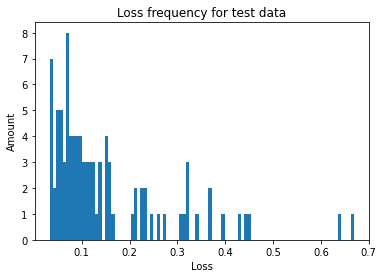

Loss average is: 0.15097002914867044
Loss mode is: [(0.16068, 1), (0.15039, 1), (0.03484, 1), (0.13374, 1), (0.36727, 1), (0.15771, 1), (0.09264, 1), (0.63837, 1), (0.11822, 1), (0.06794, 1)]
Loss median is: 0.10419


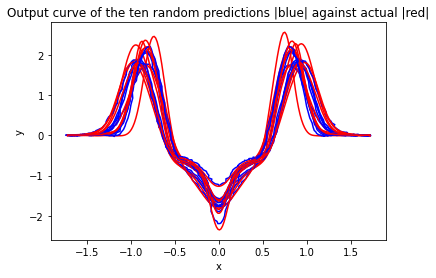

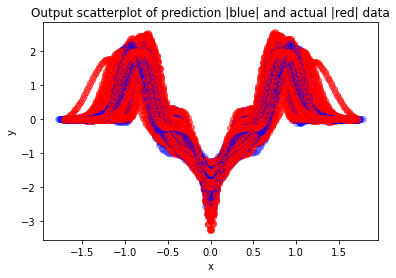

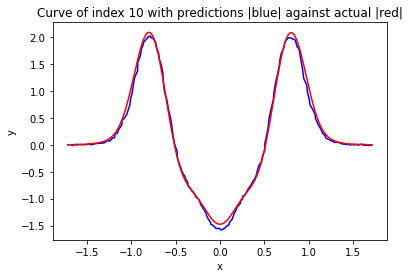

The loss of the curve 0.052845476157850645


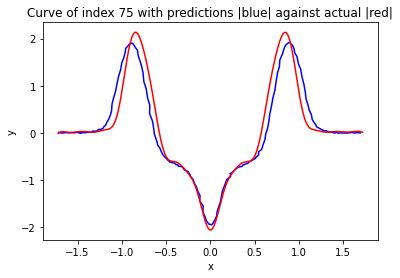

The loss of the curve 0.2090739879445651


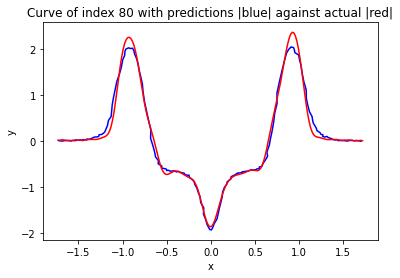

The loss of the curve 0.0882545617365672


In [37]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_2')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

Trial 254 Complete [00h 00m 19s]
val_mean_absolute_error: 0.08858266472816467

Best val_mean_absolute_error So Far: 0.08508946746587753
Total elapsed time: 00h 10m 37s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 3, 'dense_0_units': 1000, 'dropout_0': 0.15000000000000002, 'learning_rate': 0.0015516309595003499, 'dense_1_units': 400, 'dropout_1': 0.05, 'dense_2_units': 1200, 'dropout_2': 0.2, 'dense_3_units': 1200, 'dropout_3': 0.15000000000000002, 'dense_4_units': 1600, 'dropout_4': 0.25, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0241'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
____________________________________

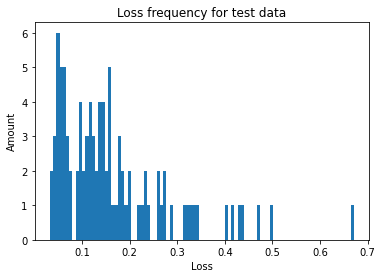

Loss average is: 0.1644766886001294
Loss mode is: [(0.11552, 1), (0.25863, 1), (0.068, 1), (0.33833, 1), (0.40484, 1), (0.11276, 1), (0.0362, 1), (0.29038, 1), (0.16749, 1), (0.11761, 1)]
Loss median is: 0.13542500000000002


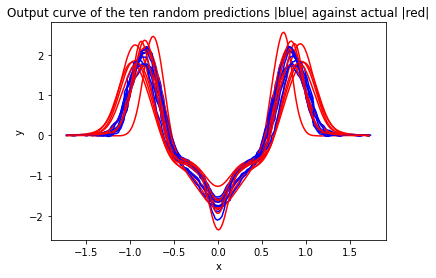

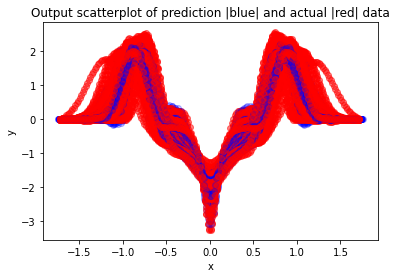

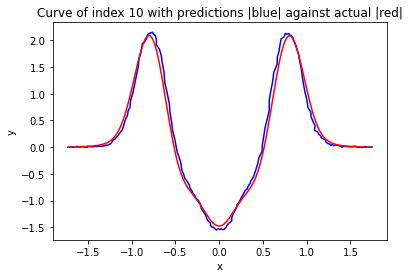

The loss of the curve 0.09928634472672149


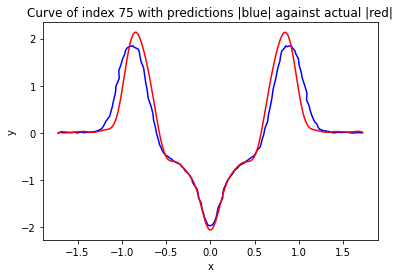

The loss of the curve 0.1767456256687068


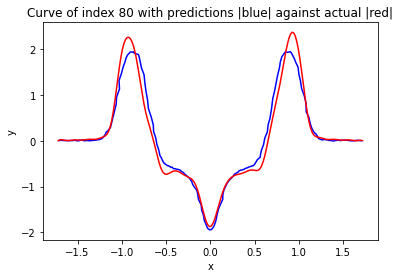

The loss of the curve 0.12114996133456046


In [38]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=200, max_value=2000, step=200),activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_absolute_error',
                  metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

tuner = Hyperband(
    build_model,
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_3')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

Trial 254 Complete [00h 00m 39s]
val_loss: 0.1287349909543991

Best val_loss So Far: 0.016797233372926712
Total elapsed time: 00h 33m 18s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 1600, 'activation': 'relu', 'dropout_0': 0.1, 'optimizer': 'adam', 'loss': 'log_cosh', 'dense_1_units': 2800, 'dropout_1': 0.05, 'dense_2_units': 600, 'dropout_2': 0.05, 'dense_3_units': 1200, 'dropout_3': 0.1, 'dense_4_units': 200, 'dropout_4': 0.25, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0228'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1600)              1601600   
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense_1 (

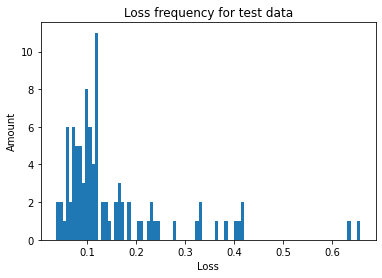

Loss average is: 0.15048869357543376
Loss mode is: [(0.18231, 1), (0.20683, 1), (0.07761, 1), (0.10076, 1), (0.11318, 1), (0.13672, 1), (0.09354, 1), (0.65848, 1), (0.09612, 1), (0.087, 1)]
Loss median is: 0.110485


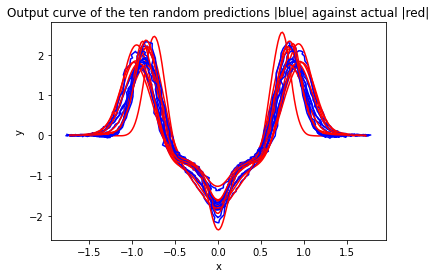

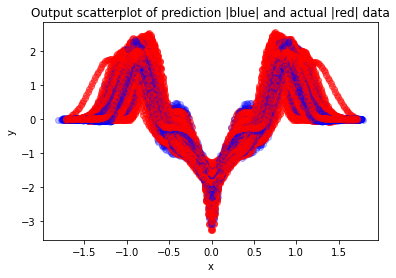

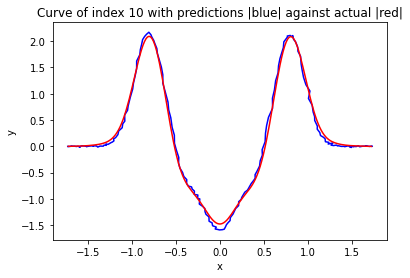

The loss of the curve 0.061834326224420616


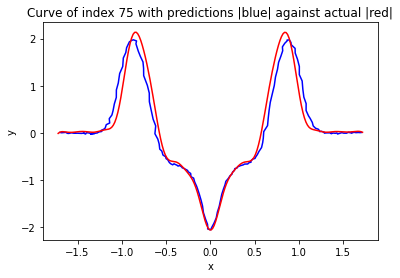

The loss of the curve 0.18524313729749042


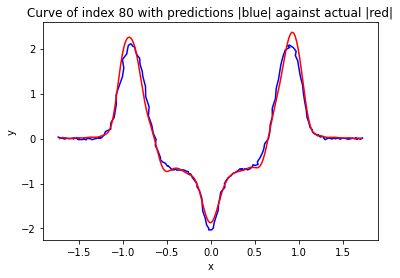

The loss of the curve 0.07475193901125374


In [44]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    #activation = hp.Choice('activation', ['relu', 'swish', 'elu'])
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=200, max_value=4000, step=200), 
                               activation=hp.Choice('activation', ['relu', 'swish', 'elu'])))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation='linear'))
    
    optimizer = hp.Choice('optimizer', ['sgd','rmsprop','adam'])
    loss = hp.Choice('loss', ['mean_squared_error', 'mean_absolute_error','huber_loss','log_cosh'])
    
    model.compile(optimizer=optimizer,loss=loss)
    
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_4')

tuner.search(train_input, train_output,
             epochs=300,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

In [45]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=200, max_value=5000, step=200), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.025, max_value=0.30, step=0.025), seed=42))
    
    model.add(layers.Dense(units=400, activation = hp.Choice('output_activation', ['linear','relu', 'swish','softplus'])))
    
    model.compile(optimizer='adam',loss='huber_loss')
    
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_5')

tuner.search(train_input, train_output,
             epochs=300,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

Trial 250 Complete [00h 01m 39s]
val_loss: 0.22538578510284424

Best val_loss So Far: 0.020150432363152504
Total elapsed time: 00h 42m 34s

Search: Running Trial #251

Value             |Best Value So Far |Hyperparameter
6                 |5                 |num_layers
2200              |400               |dense_0_units
0.275             |0.15              |dropout_0
softplus          |linear            |output_activation
2200              |3000              |dense_1_units
0.225             |0.1               |dropout_1
4400              |3200              |dense_2_units
0.275             |0.15              |dropout_2
4800              |400               |dense_3_units
0.05              |0.075             |dropout_3
4600              |1200              |dense_4_units
0.075             |0.225             |dropout_4
600               |1400              |dense_5_units
0.275             |0.175             |dropout_5
200               |200               |tuner/epochs
0                 |67  

KeyboardInterrupt: 

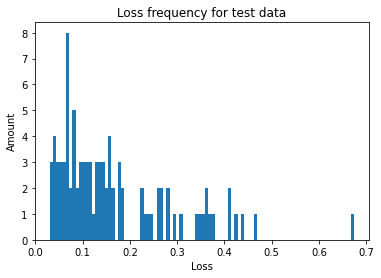

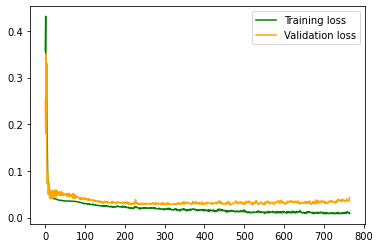

Loss average is: 0.16529277720032992
Loss mode is: [(0.06629, 1), (0.35928, 1), (0.04122, 1), (0.26724, 1), (0.16047, 1), (0.15861, 1), (0.06567, 1), (0.40834, 1), (0.22518, 1), (0.07927, 1)]
Loss median is: 0.128085
Used time: 174.42086219787598 seconds



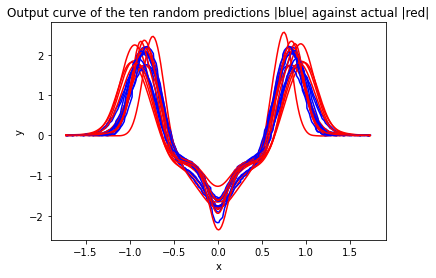

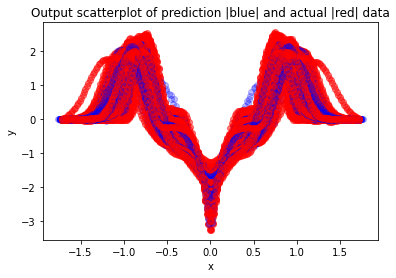

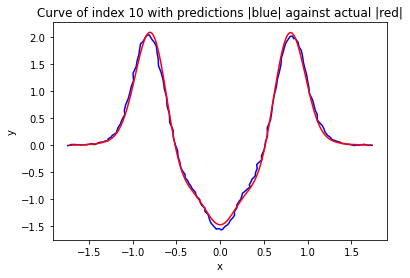

The loss of the curve 0.04396021288855663


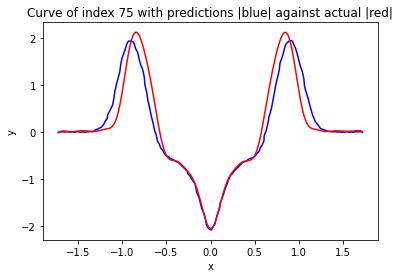

The loss of the curve 0.1817866301126495


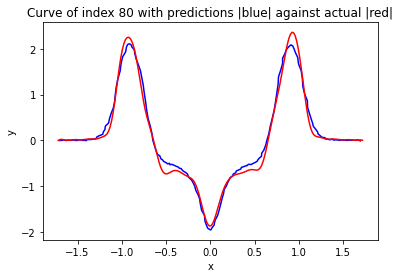

The loss of the curve 0.09687437679321427


In [5]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(400, activation='relu')(inputs)
x = layers.Dropout(0.15, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3200, activation='relu')(x)
x = layers.Dropout(0.15, seed=42)(x)
x = layers.Dense(400, activation='relu')(x)
x = layers.Dropout(0.075, seed=42)(x)
x = layers.Dense(1200, activation='relu')(x)
x = layers.Dropout(0.225, seed=42)(x)
x = layers.Dense(1400, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='huber_loss')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

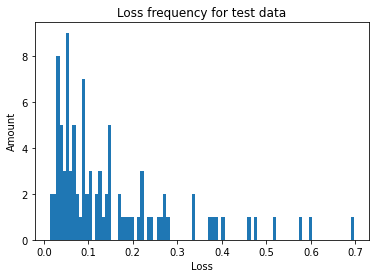

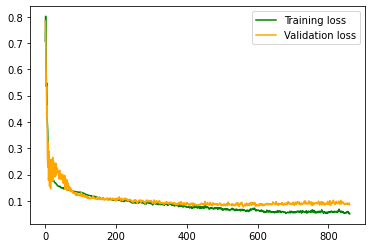

Loss average is: 0.15059587507797695
Loss mode is: [(0.04527, 1), (0.07856, 1), (0.03702, 1), (0.19588, 1), (0.0607, 1), (0.18351, 1), (0.01353, 1), (0.69737, 1), (0.25368, 1), (0.0648, 1)]
Loss median is: 0.096745
Used time: 189.880136013031 seconds



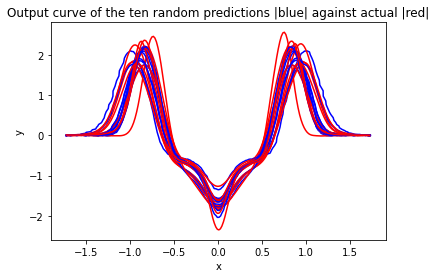

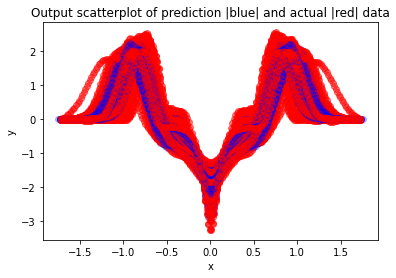

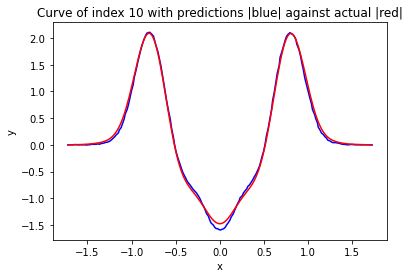

The loss of the curve 0.05520915417334742


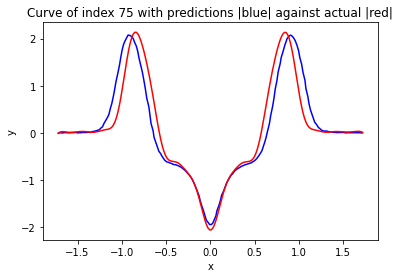

The loss of the curve 0.22237617051021322


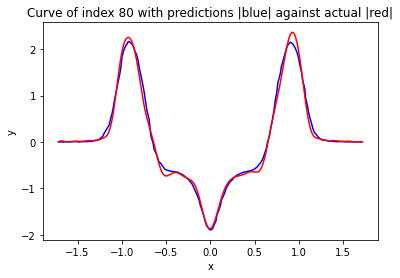

The loss of the curve 0.06629057465553037


In [6]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(400, activation='relu')(inputs)
x = layers.Dropout(0.15, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3200, activation='relu')(x)
x = layers.Dropout(0.15, seed=42)(x)
x = layers.Dense(400, activation='relu')(x)
x = layers.Dropout(0.075, seed=42)(x)
x = layers.Dense(1200, activation='relu')(x)
x = layers.Dropout(0.225, seed=42)(x)
x = layers.Dense(1400, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

Trial 254 Complete [00h 00m 19s]
val_loss: 0.09192172437906265

Best val_loss So Far: 0.07553867250680923
Total elapsed time: 00h 15m 18s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 2400, 'dropout_0': 0.025, 'dense_1_units': 1800, 'dropout_1': 0.025, 'dense_2_units': 800, 'dropout_2': 0.025, 'dense_3_units': 2600, 'dropout_3': 0.17500000000000002, 'dense_4_units': 3800, 'dropout_4': 0.17500000000000002, 'dense_5_units': 2600, 'dropout_5': 0.2, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0207'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2400)              2402400   
_________________________________________________________________
dropout (Dropout)            (None, 2400)              0         
_____________________________________________________________

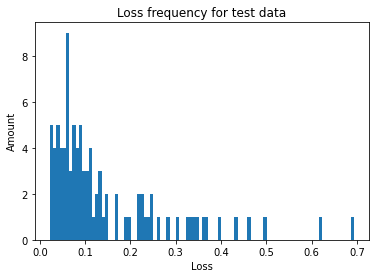

Loss average is: 0.1451673326205946
Loss mode is: [(0.17061, 1), (0.24579, 1), (0.02214, 1), (0.09016, 1), (0.22359, 1), (0.15071, 1), (0.12714, 1), (0.61962, 1), (0.11076, 1), (0.08104, 1)]
Loss median is: 0.09121


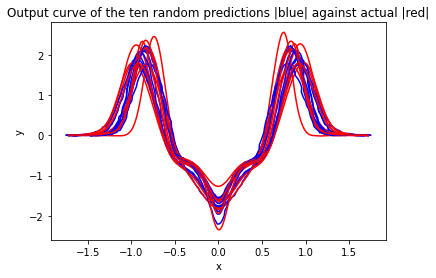

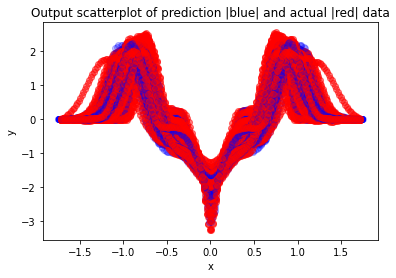

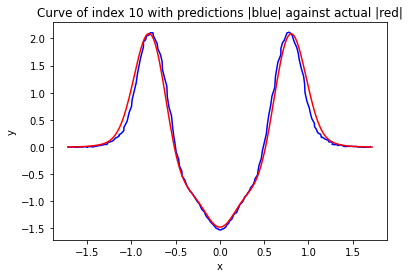

The loss of the curve 0.07283789486855975


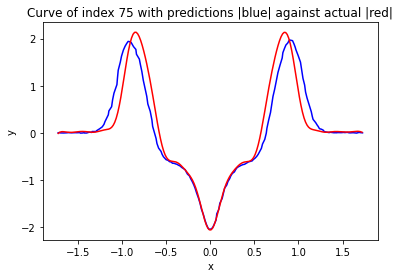

The loss of the curve 0.19585344150465417


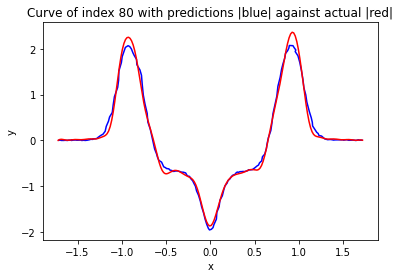

The loss of the curve 0.06622403202908321


In [5]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=5000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer='adam',loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=150,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_6')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

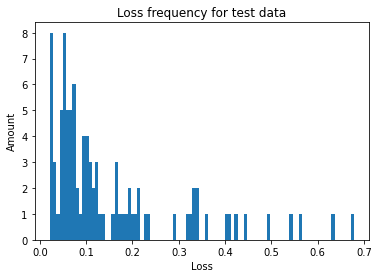

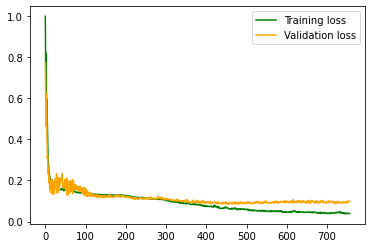

Loss average is: 0.15316047832258894
Loss mode is: [(0.05517, 1), (0.07312, 1), (0.05592, 1), (0.09294, 1), (0.05091, 1), (0.18649, 1), (0.06186, 1), (0.67876, 1), (0.33363, 1), (0.06956, 1)]
Loss median is: 0.09614
Used time: 306.61084175109863 seconds



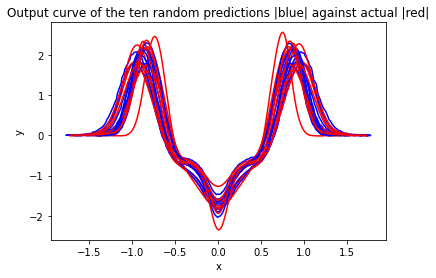

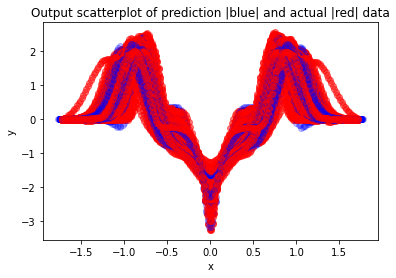

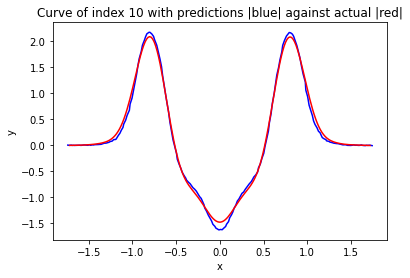

The loss of the curve 0.0711770661092849


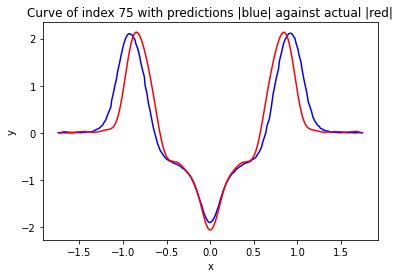

The loss of the curve 0.21609605864304982


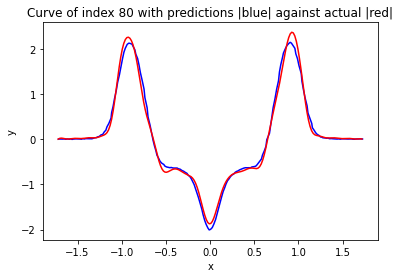

The loss of the curve 0.07438357370266284


In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2400, activation='relu')(inputs)
x = layers.Dropout(0.025, seed=42)(x)
x = layers.Dense(1800, activation='relu')(x)
x = layers.Dropout(0.25, seed=42)(x)
x = layers.Dense(800, activation='relu')(x)
x = layers.Dropout(0.025, seed=42)(x)
x = layers.Dense(2600, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
x = layers.Dense(3800, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
x = layers.Dense(2600, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

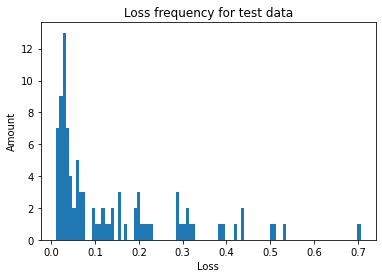

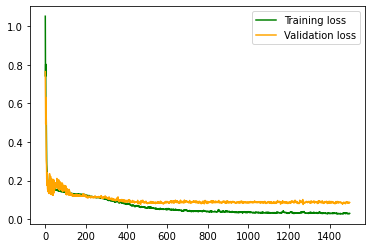

Loss average is: 0.135231785379786
Loss mode is: [(0.02999, 1), (0.07382, 1), (0.01112, 1), (0.07159, 1), (0.19069, 1), (0.19808, 1), (0.01801, 1), (0.70606, 1), (0.15259, 1), (0.05997, 1)]
Loss median is: 0.06319999999999999
Used time: 607.6225459575653 seconds



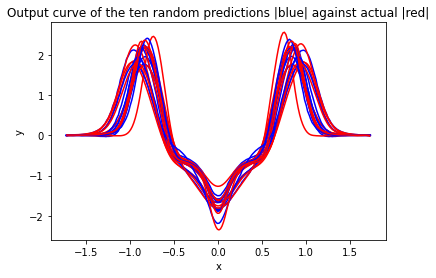

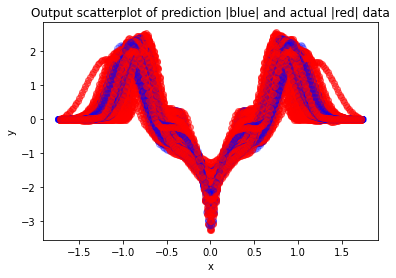

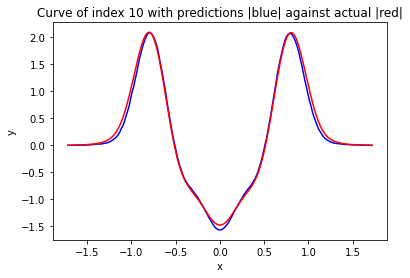

The loss of the curve 0.05589215378262117


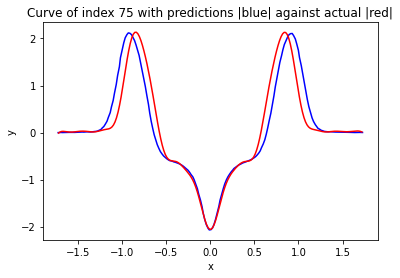

The loss of the curve 0.20079421483780138


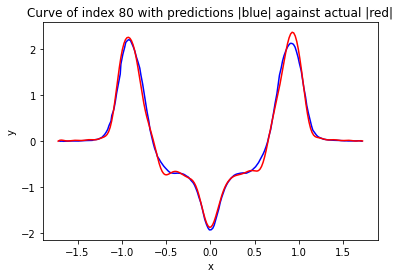

The loss of the curve 0.05891184240212976


In [9]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2400, activation='relu')(inputs)
x = layers.Dropout(0.025, seed=42)(x)
x = layers.Dense(1800, activation='relu')(x)
x = layers.Dropout(0.25, seed=42)(x)
x = layers.Dense(800, activation='relu')(x)
x = layers.Dropout(0.025, seed=42)(x)
x = layers.Dense(2600, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
x = layers.Dense(3800, activation='relu')(x)
x = layers.Dropout(0.175, seed=42)(x)
x = layers.Dense(2600, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

Trial 254 Complete [00h 00m 23s]
loss: 0.09950830042362213

Best loss So Far: 0.07426236569881439
Total elapsed time: 00h 47m 07s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 2500, 'dropout_0': 0.05, 'dense_1_units': 2000, 'dropout_1': 0.05, 'dense_2_units': 1000, 'dropout_2': 0.05, 'dense_3_units': 3000, 'dropout_3': 0.2, 'dense_4_units': 4000, 'dropout_4': 0.2, 'dense_5_units': 2500, 'dropout_5': 0.2, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0206'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2500)              2502500   
_________________________________________________________________
dropout (Dropout)            (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2

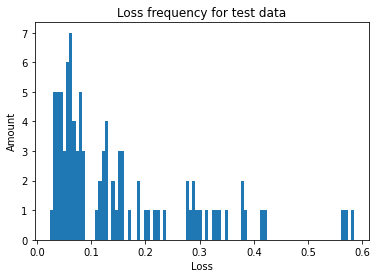

Loss average is: 0.15172606755246915
Loss mode is: [(0.22562, 1), (0.15554, 1), (0.03879, 1), (0.08018, 1), (0.12214, 1), (0.15327, 1), (0.14982, 1), (0.56958, 1), (0.11438, 1), (0.08156, 1)]
Loss median is: 0.0996


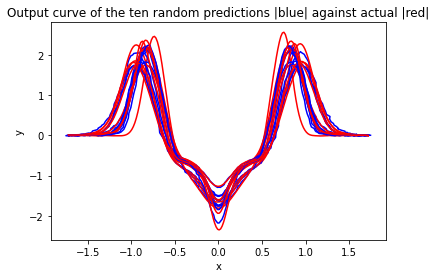

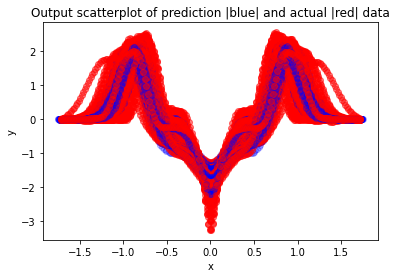

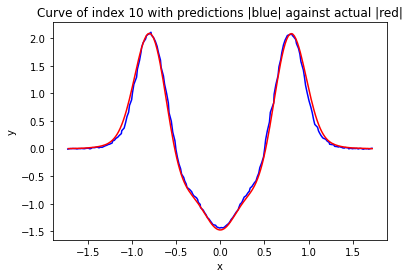

The loss of the curve 0.03847441773153495


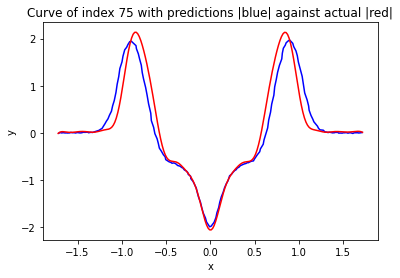

The loss of the curve 0.202904218534759


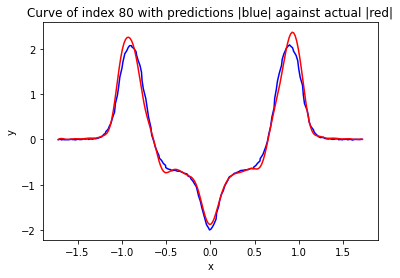

The loss of the curve 0.07194449127284165


In [10]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=5000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer='adam',loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='loss',
    max_epochs=150,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_7')

tuner.search(train_input, train_output,
             epochs=150,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

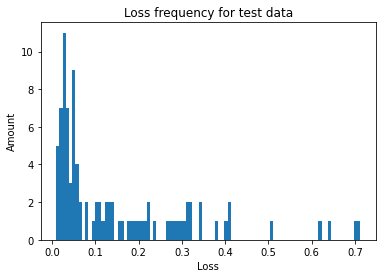

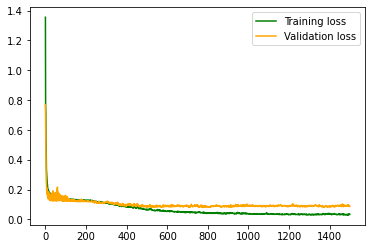

Loss average is: 0.148053455700259
Loss mode is: [(0.04774, 1), (0.05086, 1), (0.02243, 1), (0.12046, 1), (0.03191, 1), (0.21962, 1), (0.05487, 1), (0.69826, 1), (0.30925, 1), (0.04806, 1)]
Loss median is: 0.063835
Used time: 723.3721516132355 seconds



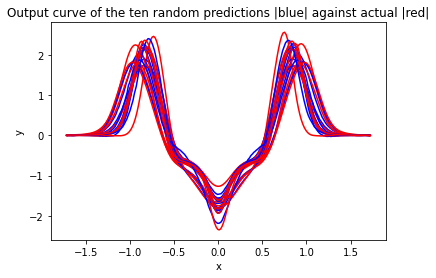

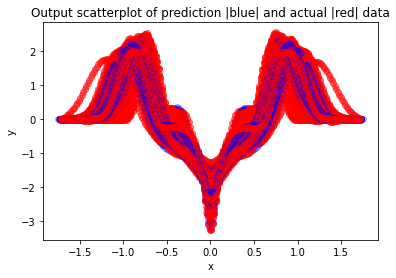

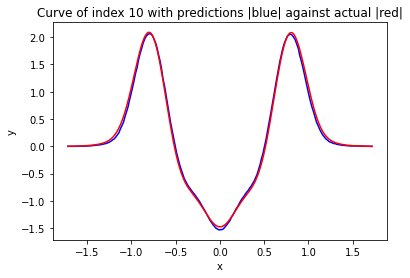

The loss of the curve 0.02990053769901722


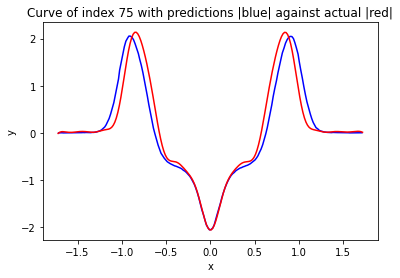

The loss of the curve 0.20029722850237433


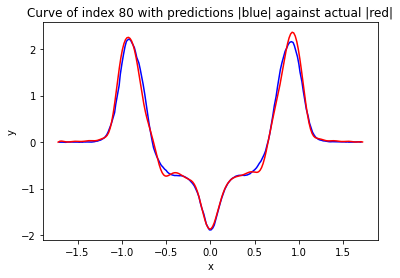

The loss of the curve 0.05260876596175266


In [11]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='loss', 
                       mode='min', 
                       patience=400, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

Trial 254 Complete [00h 02m 22s]
loss: 0.10353320091962814

Best loss So Far: 0.07841469347476959
Total elapsed time: 01h 02m 28s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 1000, 'dropout_0': 0.05, 'learning_rate': 0.001, 'dense_1_units': 1000, 'dropout_1': 0.2, 'dense_2_units': 3000, 'dropout_2': 0.1, 'dense_3_units': 3500, 'dropout_3': 0.05, 'dense_4_units': 4500, 'dropout_4': 0.15000000000000002, 'dense_5_units': 3000, 'dropout_5': 0.2, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0205'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
________________________________________________________________

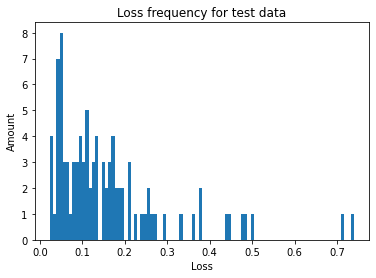

Loss average is: 0.16166903681193293
Loss mode is: [(0.0352, 1), (0.22839, 1), (0.04323, 1), (0.1052, 1), (0.37514, 1), (0.15777, 1), (0.04654, 1), (0.71195, 1), (0.1119, 1), (0.10918, 1)]
Loss median is: 0.12356500000000001


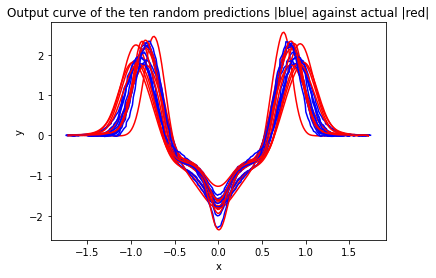

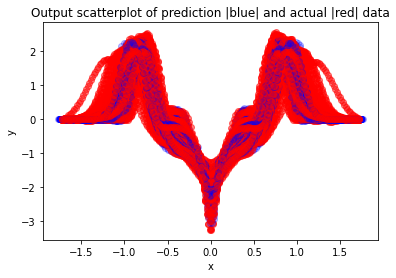

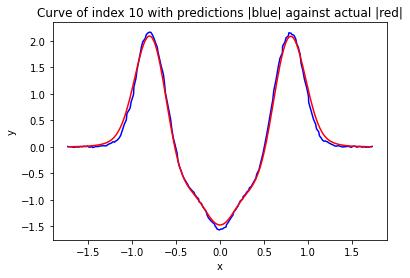

The loss of the curve 0.061771010130155055


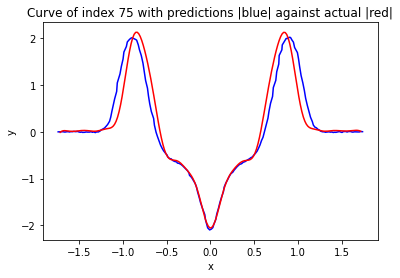

The loss of the curve 0.1486912859625429


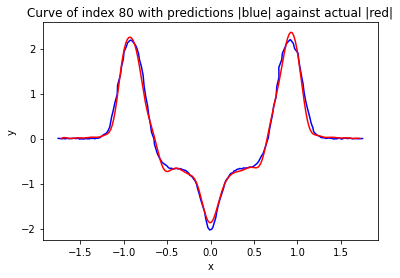

The loss of the curve 0.07920534062933995


In [15]:
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=5000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer=Adam(amsgrad=True, learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='loss',
    max_epochs=150,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_8')

tuner.search(train_input, train_output,
             epochs=150,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
plots(test_output,best_model.predict(test_input))

In [ ]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=500, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.05, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

results = metrics(test_output, model.predict(test_input))
plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))